# Climate risk to rice labour
Rice is an important part of the global food supply. It provides half
of calories consumed in Asia. Frequently, rice is harvested by hand.
This can be strenuous work, often in hot and humid conditions. Hot and
humid conditions are projected to become more common due to global
warming.

In this notebook, a global climate model is combined with crop
calendars in order to identify locations in which workers engaged in
rice harvest may already be affected by hot and humid weather, and the
extent to which this will increase with global warming.

This is intended as an illustration of a more complete analysis, which
you can follow and reproduce on your own computer.
For this reason, we use only one climate model, and only one future
pathway for emissions.

See the preprint for a more in-depth discussion:
[Regional disparities and seasonal differences in climate risk to rice labour](https://doi.org/10.31223/X5SW3N)

In [1]:
# Use this cell if the conda environment is not already set up
#!. ../env.sh rh202105 ../environment.yml >> env_build_log.txt

In [2]:
# Imports

# Relative import workaround
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import psychrolib as psl
import regionmask
import seaborn as sns
import warnings
import xarray as xr

from collections import defaultdict
from intake import open_catalog
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from pathlib import Path
from scipy import stats

from src import Labour

absolute_zero = -273.15
psl.SetUnitSystem(psl.SI)
plt.style.use("seaborn-colorblind")

# Dictionary for translating month names
month_dict = defaultdict(lambda: -1)
for i in range(1, 13):
    month_dict[calendar.month_abbr[i]] = i
month_dict[None] = -1

# Silence warning about dividing by 0 or nan.
np.seterr(divide="ignore", invalid="ignore")
warnings.filterwarnings("once", ".*No gridpoint belongs to any region.*")
warnings.filterwarnings("once", ".*Geometry is in a geographic CRS.*")
warnings.filterwarnings("once", ".*invalid value .*")
warnings.filterwarnings("once", ".*All-NaN slice.*")
warnings.filterwarnings("once", ".*invalid value encountered in.*")

In [3]:
# Create a dask cluster
# If this is a multi-core machine this will enable multi-threading.
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:42541 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 12.32 GiB


## RiceAtlas

"...a spatial database on the seasonal distribution of the world’s rice
production. It consists of data on rice planting and harvesting dates by
growing season and estimates of monthly production for all rice-producing
countries. Sources used for planting and harvesting dates include global and
regional databases, national publications, online reports, and expert
knowledge."

[Laborte, A. G. et al., 2017](https://www.nature.com/articles/sdata201774)

Details of loading the RiceAtlas data are handled by
[../src/RiceAtlas.py](../src/RiceAtlas.py)

The RiceAtlas dataset provides detailed data on rice production, broken
down into location entities with an average area of 5000 km2. Information
such as yield, harvested area, planting and harvesting dates are included,
and many entities have multiple yearly harvests. The data are representative
of the years 2010-2012. We used this to identify harvest dates. Location
entities in RiceAtlas vary greatly in size, and many are much smaller than
the grid spacing of the climate models considered.

RiceAtlas has one row per location. The locations have geometries
provided. Some are much larger that others.

Within each row, there is information for multiple cropping seasons.
For example, the columns 'P_S1', 'P_S2', and 'P_S3', give production
in the first, second and third cropping season.
The number of columns does not change between rows, and there are
always entries for 3 cropping seasons. If there are not 3 croppping
seasons in a location, then the production will be 0 for that season.

In [4]:
from src.RiceAtlas import ra

ra

# Reduce scope of RiceAtlas data
ra = ra[ra.CONTINENT == "Asia"]

# Print some data
ra[["COUNTRY", "REGION", "SUB_REGION", "P_S1", "P_S2", "P_S3"]].sample(10)

,COUNTRY,REGION,SUB_REGION,P_S1,P_S2,P_S3
1556,Bangladesh,Khulna,Bagerhat,225233.0,214146.0,22926.0
864,Nepal,Rapti,Dang Deokhuri,19977.0,0.0,0.0
1772,India,Jharkhand,Deoghar,228460.0,8228.0,0.0
1764,India,Jammu and Kashmir,Kupwara (Muzaffarabad),37731.0,0.0,0.0
102,Turkey,Turkey,Turkey,880000.0,0.0,0.0
2017,India,Uttar Pradesh,Lucknow,162501.0,0.0,0.0
1924,India,Rajasthan,Bhilwara,871.0,0.0,0.0
1652,India,Bihar,Darbhanga,20875.0,79950.0,16108.0
2093,India,Madhya Pradesh,Sehore,2093.0,0.0,0.0
491,Vietnam,South Central Coast,Quang Nam,215916.0,0.0,202090.0


We can use the RiceAtlas data to spatially subset the climate data.  However,
the method below assumes that that the latitude and longitude are defined
with consistent conventions between the climate data and the RiceAtlas data,
so be careful.

In [5]:
# Define region to spatially subset
def asia_only(da):
    minx, miny, maxx, maxy = ra[ra.CONTINENT == "Asia"].total_bounds
    return (
        da.where(da.lat > miny, drop=True)
        .where(da.lat < maxy, drop=True)
        .where(da.lon > minx, drop=True)
        .where(da.lon < maxx, drop=True)
    )

## CMIP6
Using the latest generation of climate models, we look for trends in
local changes in WBGT against global climate change.

In the full analysis, we experimented with daily and 3-hourly data. To keep
the computing requirements low for this example, we use monthly data and only
one climate model. The results are fairly similar to the full analysis.

We will access the climate model data from the cloud, as this is very
convenient for an open example.

We will use SSP 585 which is the highest greenhouse gas emission scenario
that the IPCC uses. This will give plenty of variation in GSAT, but some have
criticised it as an unrealistic scenario. In fact, we have found that this
analysis mostly depends on GSAT, irrespective of scenario or model.


* 'tas' = mean near-surface air temperature (Kelvin)
* 'tasmax' = max near-surface air temperature (Kelvin)
* 'huss' = humidity ratio (dimensionless)
* 'ps' = near-surface pressure (Pa)
* 'sftlf' = gridcell land fraction
* 'areacella' = gridcell area


* [Eyring, V. et al., 2016](https://doi.org/10.5194/gmd-9-1937-2016)
* [O’Neill, B. C. et al., 2016](https://doi.org/10.5194/gmd-9-3461-2016)

In [6]:
# Use intake to access pangeo catalogue, get data from GCS.
cat = open_catalog(
    "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
)

Let's get the climate variables we will need for the wet-bulb temperature (WBT) calculation.

In [7]:
CMIP6_variables = ["tas", "tasmax", "huss", "ps"]
CMIP6_experiments = ["historical", "ssp585"]
CMIP6_search = {
    "source_id": "UKESM1-0-LL",
    "experiment_id": CMIP6_experiments,
    "variable_id": CMIP6_variables,
    "table_id": "Amon",  # This could be changed to 'daily'
    "grid_label": "gn",
    "member_id": "r1i1p1f2",
}

cat_return = cat.climate.cmip6_gcs.search(**CMIP6_search)

# I combine by coordinates - this means the SSP will be appended to the historical experiment.
# This would cause problems if more SSPs were added to this example.
ds = (
    xr.combine_by_coords(
        cat_return.to_dataset_dict(zarr_kwargs={"consolidated": True}).values(),
        combine_attrs="drop",
    )
    .drop("height")
    .squeeze()
)
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 3012)
Coordinates:
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    member_id  <U8 'r1i1p1f2'
Dimensions without coordinates: bnds
Data variables:
    huss       (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>

In [8]:
CMIP6_variables = ["tas", "tasmax", "huss", "ps"]
CMIP6_experiments = ["historical", "ssp585"]
CMIP6_search = {
    "source_id": "UKESM1-0-LL",
    "experiment_id": CMIP6_experiments,
    "variable_id": CMIP6_variables,
    "table_id": "Amon",  # This could be changed to 'daily'
    "grid_label": "gn",
    "member_id": "r1i1p1f2",
}

cat_return = cat.climate.cmip6_gcs.search(**CMIP6_search)

# I combine by coordinates - this means the SSP will be appended to the historical experiment.
# This would cause problems if more SSPs were added to this example.
ds = (
    xr.combine_by_coords(
        cat_return.to_dataset_dict(zarr_kwargs={"consolidated": True}).values(),
        combine_attrs="drop",
    )
    .drop("height")
    .squeeze()
)
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 3012)
Coordinates:
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    member_id  <U8 'r1i1p1f2'
Dimensions without coordinates: bnds
Data variables:
    huss       (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>

Regardless of whether we are using monthly/daily/3-hourly data for the analysis,
we will want monthly surface air temperature for calculating global
near-surface air temperature (GSAT).

In [9]:
CMIP6_search_gsat = CMIP6_search
CMIP6_search_gsat["variable_id"] = "tas"
CMIP6_search_gsat["table_id"] = "Amon"
cat_return = cat.climate.cmip6_gcs.search(**CMIP6_search_gsat)
ds_tas = (
    xr.combine_by_coords(
        cat_return.to_dataset_dict(zarr_kwargs={"consolidated": True}).values(),
        combine_attrs="drop",
    )
    .drop("height")
    .squeeze()
)
ds_tas


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 3012)
Coordinates:
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    member_id  <U8 'r1i1p1f2'
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>

Cell area and land fraction grids are the same for all scenarios, and the
data is not necessarily separately available for each scenario, so we should
not include the scenario information in its search.

In [10]:
# Cell area
CMIP6_search_areacella = {
    "source_id": CMIP6_search["source_id"],
    "variable_id": "areacella",
    "grid_label": "gn",
}
cat_return = cat.climate.cmip6_gcs.search(**CMIP6_search_areacella)
ds_areacella = xr.combine_by_coords(
    cat_return.to_dataset_dict(zarr_kwargs={"consolidated": True}).values(),
    combine_attrs="drop",
).squeeze()
ds_areacella


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192)
Coordinates:
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    member_id  <U8 'r1i1p1f2'
Dimensions without coordinates: bnds
Data variables:
    areacella  (lat, lon) float32 dask.array<chunksize=(144, 192), meta=np.ndarray>

In [11]:
# Land fraction
CMIP6_search_sftlf = {
    "source_id": CMIP6_search["source_id"],
    "variable_id": "sftlf",
    "grid_label": "gn",
}
cat_return = cat.climate.cmip6_gcs.search(**CMIP6_search_sftlf)
ds_sftlf = xr.combine_by_coords(
    cat_return.to_dataset_dict(zarr_kwargs={"consolidated": True}).values(),
    combine_attrs="drop",
).squeeze()
ds_sftlf


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192)
Coordinates:
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    type       |S4 ...
    member_id  <U8 'r1i1p1f2'
Dimensions without coordinates: bnds
Data variables:
    sftlf      (lat, lon) float32 dask.array<chunksize=(144, 192), meta=np.ndarray>

## Climate Change
Calculate global mean surface air temperature, i.e. global climate change.

Generally global warming is defined either in terms of near surface air
temperatures, or surface temperatures.  They do not give exactly the same
result.

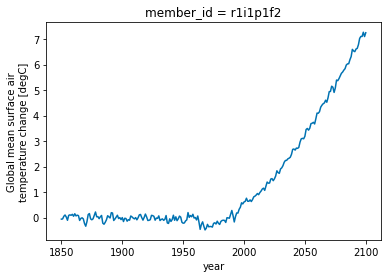

In [12]:
gsat = (
    ds_tas.tas.weighted(ds_areacella.areacella)
    .mean(("lat", "lon"))
    .resample(time="Y")
    .mean()
    .compute()
)
gsat_reference = gsat.sel(time=slice("1850", "1900")).mean("time")
gsat_change = (gsat - gsat_reference).groupby("time.year").first()

gsat_change.attrs = ds_tas.tas.attrs
gsat_change.attrs["long_name"] = "Global mean surface air temperature change"
gsat_change.attrs["short_name"] = "GSAT change"
gsat_change.attrs["units"] = "degC"

gsat_change.plot()
plt.show()

Temperatures are in kelvin by default - I want them in Celsius. Watch out, running this cell out of order will cause big problems!

In [13]:
for var in ["tas", "tasmax"]:
    print(f"Changing units of {var} K->degC")
    attrs = ds[var].attrs
    attrs["units"] = "degC"
    ds[var] = ds[var] + absolute_zero
    ds[var].attrs = attrs

Changing units of tas K->degC
Changing units of tasmax K->degC


Because of compression, huss will sometimes have small negative values, which is not valid.
It should be zero bounded.

In [14]:
ds["huss"] = ds.huss.where(ds.huss > 0, 0)

Reduce scope based on the geographic limits of the RiceAtlas data we have
selected,  selecting only land using sftlf.

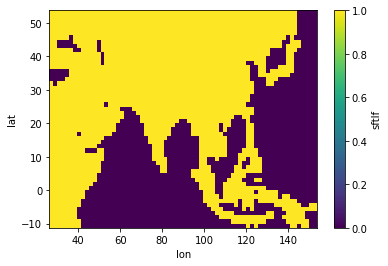

In [15]:
valid_gridcells = ds_sftlf.sftlf.pipe(asia_only).pipe(lambda _da: _da > 0)
valid_gridcells = valid_gridcells.drop("type").drop("member_id")
ds = ds.pipe(asia_only).where(valid_gridcells)
valid_gridcells.plot()
plt.show()

Add in date auxillaries
This is just more convenient in some cases than using ds.time.dt.year

In [16]:
ds["dayofyear"] = ds.time.dt.dayofyear
ds["year"] = ds.time.dt.year

## Heat stress index
Wet-bulb globe temperature (WBGT) is a heat-stress metric defined by ISO 7243
and widely used for assessing hazards due to hot conditions. WBGT is
intended to combine the factors that affect the human experience of heat:
namely air temperature, radiant temperature, humidity, and air
velocity. WBGT is designed to be measured directly using specialised
equipment; in practice, statistical and empirical formulae for estimating
it from standard meteorological variables must be used in the climate
context. We assumed that work occurs in the shade, so that air
temperature approximates black-globe temperature (BGT).  Furthermore,
cloud cover is one of the most uncertain aspects of global climate
models.

In the supplementary material of the full article, we explore the effect of
excluding radiation: although this leads to underestimation of heat stress in
some conditions, it makes little difference to long-term trends and is
consistent with other related studies.

WBGT was calculated as WBGT = 0.7*WBT + 0.3*BGT, where WBT is the wet-bulb
temperature. WBT was calculated from air temperature, specific humidity, and
pressure using open-source software
[psychrolib](https://github.com/psychrometrics/psychrolib) which implements
formulae from the American Society of Heating, Refrigerating and
Air-Conditioning Engineers handbook. Field measured WBT decreases with wind
speed at low speed (<2 m/s, a light breeze), but higher wind speeds have a
lesser effect23. The WBT calculation used is consistent with a light breeze,
and variation in wind speed is neglected.

See references re WBGT:
Epstein, Y. & Moran, D. S. Thermal Comfort and the Heat Stress Indices. Ind. Health 44, 388–398 (2006).
Parsons, K. Heat stress standard ISO 7243 and its global application. Industrial Health vol. 44 368–379 (2006).
Parsons, K. Occupational Health Impacts of Climate Change: Current and Future ISO Standards for the Assessment of Heat Stress. Ind. Health 51, 86–100 (2013).

In [17]:
for WBGT, WBT, Ta in (
    ("wbgt_max", "wbt_max", "tasmax"),
    ("wbgt_mean", "wbt_mean", "tas"),
):
    # Specify WBT calculation, using psychrolib.
    ds[WBT] = xr.apply_ufunc(
        psl.GetTWetBulbFromHumRatio,
        ds[Ta],
        ds["huss"],
        ds["ps"],
        dask="parallelized",
        output_dtypes=[float],
    )

    # Calculate WBGT, assuming the black globe temperature is approximated by the
    # air temperature. This will be approximately true in the shade.
    ds[WBGT] = ds[WBT] * 0.7 + ds[Ta] * 0.3
    ds[WBGT].attrs = {
        "units": "degC",
        "long_name": "Wet-bulb globe temperature",
        "short_name": WBGT,
    }
ds["wbgt_mid"] = (ds["wbgt_max"] + ds["wbgt_mean"]) / 2

You can see that WBGT is related to air temperature, but does not have a 1:1 relationship.

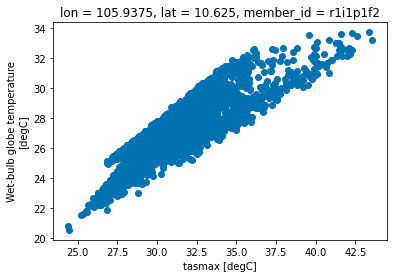

In [18]:
ds.sel(lat=10.0634, lon=105.5943, method="nearest").plot.scatter("tasmax", "wbgt_max")
plt.show()

In some places where rice production is prevalent, WBGT gets above 24 C regularly.
Note this is model data so probably has a systematic bias.
Also, at smaller scales there will be more extremes: climate models average
over large areas.

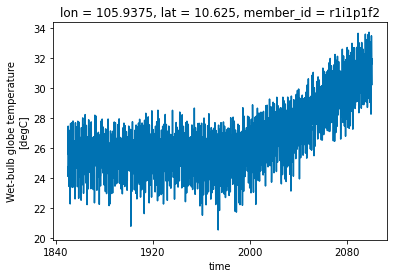

In [19]:
ds["wbgt_max"].sel(lat=10.0634, lon=105.5943, method="nearest").plot()
plt.show()

## Labour effect
Sahu, Sett and Kjellstrom (2019) observed a 5% per °C WBGT decrease in the
labour capacity of labourers harvesting rice between 23-33 °C WBGT. Rate of
collection was measured in 124 workers in groups of 10-18, and WBGT was
measured in-situ, at an individual location in India. We adopt this for our
labour impact metric and assume that this is representative of manual rice
harvest labour. The impact is assumed to be linear in WBGT, although this
assumption must break down at high WBGT (>35 °C). The systematic uncertainty
due to these assumptions cannot be assessed without larger scale field
observations. The labour loss function is 5.14*WBGT- 218, in units of %,
clipped at 0 and 100. This means that 0% loss occurs at 23 °C and 100% loss
occurs at 42.5 °C.

To facilitate comparison to other studies, results were also calculated using
different assumptions about the relationship between WBGT and labour
productivity: the heavy labour assumption used in Dunne, Stouffer, and John
(2013), and the heavy labour assumption used in Orlov et al. (2020). Our
calculations are consistent with these other studies.

* Sahu, S., Sett, M. & Kjellstrom, T. Heat Exposure, Cardiovascular Stress and Work Productivity in Rice Harvesters in India: Implications for a Climate Change Future. Ind. Health 51, 424–431 (2013).
* Dunne, J. P., Stouffer, R. J. & John, J. G. Reductions in labour capacity from heat stress under climate warming. Nat. Clim. Chang. 3, 563–566 (2013).
* Orlov, A., Sillmann, J., Aunan, K., Kjellstrom, T. & Aaheim, A. Economic costs of heat-induced reductions in worker productivity due to global warming. Glob. Environ. Chang. 63, (2020).
* Gosling, S. N., Zaherpour, J. & Ibarreta, D. PESETA III: Climate change impacts on labour productivity. (Publications Office of the European Union, 2018). doi:10.2760/07911.

Other labour impact functions are included in [../src/Labour.py](../src/Labour.py), so you
could explore how the choice of labour impact function affects the results,
and even define your own.
You can see these different assumptions plotted below.

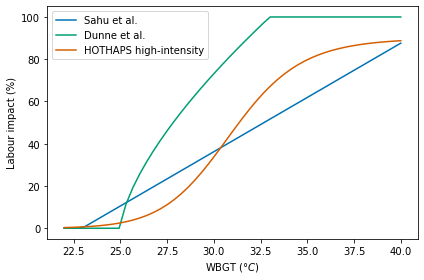

In [20]:
fig, ax = plt.subplots()
x = np.linspace(22, 40)
for loss, name in [
    ("labour_sahu", "Sahu et al."),
    ("labour_dunne", "Dunne et al."),
    ("labour_hothaps_high", "HOTHAPS high-intensity"),
]:
    ax.plot(x, Labour.__dict__[loss](x), label=name)

ax.set_ylabel("Labour impact (%)")
ax.set_xlabel("WBGT ($\degree C$)")
plt.tight_layout()
plt.legend()
plt.show()


The '4+4+4' assumption means that air temperature in the working day is
assumed to be close to the maxmimum for 4 hours, the mean for 4 hours, and
half-way between for 4 hours. This is a reasonably good approximation.  This
assumption comes from Kjellstrom et al. (2018) but also gets used in several
other papers including Orlov et al (2020) and Watts et al (2021).
In the supplementary material of the main article, we explore the effect of
using 3-hourly CMIP6 data instead of the 4+4+4 data, and get similar results overall.

* Kjellstrom, T., Freyberg, C., Lemke, B., Otto, M. & Briggs, D. Estimating population heat exposure and impacts on working people in conjunction with climate change. Int. J. Biometeorol. 62, 291–306 (2018).
* Watts, N. et al. The 2020 report of The Lancet Countdown on health and climate change: responding to converging crises. The Lancet vol. 397 129–170 (2021).

In [21]:
labour_ds_list = []
for labour_func_name in ("labour_sahu", "labour_dunne", "labour_hothaps_high"):
    labour_ds_list.append([])
    for WBGT_stat in (
        "max",
        "mean",
        "mid",
    ):
        WBGT = f"wbgt_{WBGT_stat}"
        func = Labour.__dict__[labour_func_name]

        labour_ds_list[-1].append(
            xr.apply_ufunc(
                func, ds[WBGT], dask="parallelized", output_dtypes=[float]
            ).assign_coords({"labour_func": labour_func_name, "wbgt_stat": WBGT_stat})
        )
        # print("A", func(ds[WBGT].isel(time=-6)).max().compute()) # Just checking
        # print("B", labour_ds_list[-1][-1].isel(time=-6).max().compute()) # Just checking

ds_labourloss = (
    xr.combine_nested(
        labour_ds_list,
        concat_dim=[
            "labour_func",
            "wbgt_stat",
        ],
    )
    .mean("wbgt_stat")
    .to_dataset(name="labour")
)
ds_labourloss.labour.attrs = {
    "long_name": "Labour lost due to heat stress",
    "short_name": "lost_labour",
    "units": "%",
}

Now we want to calculate correlations between annual GSAT and labour loss for
each gridcell for each month. A key hypothesis of this work is that these
are highly correlated.

Independently for each climate model, and for each location and season, a
linear trend was fitted between the the change in the global mean
near-surface air temperature (GSAT) and the labour productivity metric. Data
from historical model runs and SSPs were included together in a single fit,
so that a range of GSAT values were included; but each model, and harvest
season and location was fit independently.

We defined the gradient of this fit as the “hazard gradient”, the purpose of
which is to summarise the relationship between changes in GSAT and local
changes in labour productivity via WBGT, to explore the spatial patterns of
change. This effectively collapses variation in time, the climate sensitivity
of each model, and emissions scenario into a single dimension.

In [22]:
def new_linregress(x, y):
    """Wrapper around scipy linregress to use in apply_ufunc"""
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])


def fit_parallel_wrapper(
    x: xr.DataArray, y: xr.DataArray, dim: str = "time"
) -> xr.DataArray:
    """Do a linear fit along an axis, independently in other dimensions.
    Different outputs of the fit are arranged along a new dimension, to get
    around the limitation that xr.apply_ufunc can only take a single variable
    output.
    """
    # return a new DataArray
    result = xr.apply_ufunc(
        new_linregress,
        x,
        y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[["linregress"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=["float64"],
        output_sizes={"parameter": 5},
    )
    result = result.assign_coords(
        {"linregress": ["slope", "intercept", "rvalue", "pvalue", "stderr"]}
    )
    return result

Fit independently for each month and gridcell.  Note that the data array
needs to contain monthly data by this point, even if you started with daily
or subdaily data.

In [23]:
# Invoke computation of the monthly labour loss.
# This will be about 122MB in the stock configuration of this notebook.
ds_labourloss.to_netcdf(
    "data/ds_labourloss.nc", encoding={"labour": {"dtype": "float32"}}
)

ds_labourloss = xr.open_dataset("data/ds_labourloss.nc")

In [24]:
ds_monthly_trends = ds_labourloss.labour.groupby("time.month").apply(
    lambda x: fit_parallel_wrapper(
        gsat_change, x.groupby("time.year").mean().sel(year=gsat_change.year), "year"
    )
)

<ipython-input-22-e794a014dadf>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-22-e794a014dadf>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-22-e794a014dadf>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-22-e794a014dadf>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-22-e794a014dadf>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direc

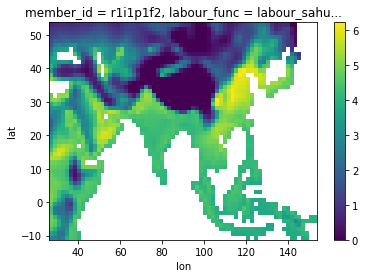

In [25]:
ds_monthly_trends.sel(labour_func="labour_sahu", linregress="slope").max(
    "month"
).plot()
plt.show()

Fit for each gridcell with the whole year average.

In [26]:
ds_yearly_trends = (
    ds_labourloss.labour.groupby("time.year")
    .mean()
    .pipe(
        lambda x: fit_parallel_wrapper(
            gsat_change, x.sel(year=gsat_change.year), "year"
        )
    )
)

<ipython-input-22-e794a014dadf>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(


## Using the RiceAtlas data

Now we will use the data in the RiceAtlas shapefile to create masks and
weightings for our results.

In [27]:
# Use regionmask to start with
regions = regionmask.from_geopandas(ra, names="HASC")
mask = regions.mask(ds.lon, ds.lat)
# Turn regions into dimensions instead
mask_regions = xr.concat([(mask == r.number) for r in regions], dim="region")
mask_regions["region"] = ra.HASC.values

all_masks = []
all_weights = []
peak_months = []
for i_region, region in ra.iterrows():
    months = [month_dict[m] for m in region[[f"HMO_PK{i}" for i in (1, 2, 3)]]]
    weights = region[[f"P_S{i}" for i in (1, 2, 3)]].astype(float).values
    single_mask = mask == regions[region.HASC].number
    if not single_mask.any():
        single_mask = valid_gridcells.sel(
            lon=[region.geometry.centroid.x],
            lat=[region.geometry.centroid.y],
            method="nearest",
        )

    single_mask = (
        single_mask.assign_coords({"HASC": region.HASC})
        .expand_dims(("HASC"))
        .to_dataset(name="mask")
    )
    all_masks.append(single_mask)

    all_weights.append(
        xr.DataArray(
            weights.reshape(-1, 1),
            dims=("season", "HASC"),
            coords={
                "season": np.array([1, 2, 3]),
                "HASC": np.array(region.HASC).reshape(1),
            },
        )
    )

    peak_months.append(
        xr.DataArray(
            np.array(months).reshape(-1, 1),
            dims=("season", "HASC"),
            coords={
                "season": np.array([1, 2, 3]),
                "HASC": np.array(region.HASC).reshape(1),
            },
        )
    )


ds_mask = xr.concat(all_masks, dim="HASC")
ds_mask["mask"] = ds_mask["mask"] > 0
da_weights_seasonal = xr.concat(all_weights, dim="HASC")
da_peak_months = xr.concat(peak_months, dim="HASC")

## Example: West Bengal
West Bengal is a state in the east of India.
We will examine the results of our analysis for just this location in order
to better understand the overall trends and meaning of the analyis.

For convenience, I will just use a single sub-region of West Bengal, but this won't affect the result much.

Firstly, what does the trend in daily maximum WBGT look like in this scenario.

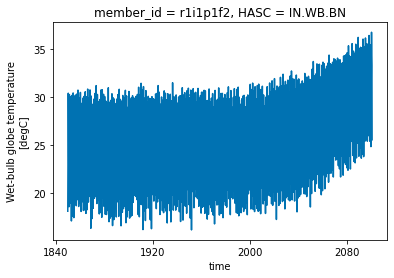

In [28]:
HASC_local = ra[ra.REGION == "West Bengal"].HASC.head(1).item()
mask_local = ds_mask.sel(HASC=HASC_local).mask
ds["wbgt_max"].where(mask_local).mean(("lat", "lon"), keep_attrs=True).plot()
plt.show()

... and what does that mean for labour productivity?

We can see that in the historical simulations, labour loss peaks at about
30%, whereas by the end of the century, it gets up to 60% in this location.

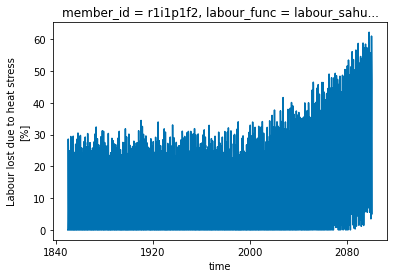

In [29]:
ds_labourloss.sel(labour_func="labour_sahu").where(mask_local).mean(
    ("lat", "lon"), keep_attrs=True
).labour.plot()
plt.show()

Actually, in the long term, the *local* labour loss that we have calculated
is strongly correlated with *global* mean surface air-temperature.

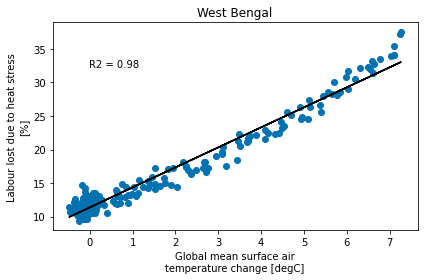

In [30]:
ds_labourloss_yearly = (
    ds_labourloss[["labour"]]
    .sel(labour_func="labour_sahu")
    .where(mask_local)
    .mean(("lat", "lon"), keep_attrs=True)
    .groupby("time.year")
    .mean(keep_attrs=True)
)
ds_labourloss_yearly["gsat_change"] = gsat_change
fig, ax = plt.subplots()
ds_labourloss_yearly.plot.scatter("gsat_change", "labour", ax=ax)

# Get the gradient we fitted
slope = (
    ds_yearly_trends.sel(linregress="slope", labour_func="labour_sahu")
    .where(mask_local)
    .mean(("lat", "lon"))
    .compute()
    .values
)
intercept = (
    ds_yearly_trends.sel(linregress="intercept", labour_func="labour_sahu")
    .where(mask_local)
    .mean(("lat", "lon"))
    .compute()
    .values
)
R2 = (
    ds_yearly_trends.sel(linregress="rvalue", labour_func="labour_sahu")
    .where(mask_local)
    .min(("lat", "lon"))
    .compute()
    .values
)
trendline = gsat_change * slope + intercept
ax.plot(gsat_change, trendline, color="k")
plt.text(
    0.1,
    0.8,
    f"R2 = {R2:0.2f}",
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes,
)
plt.title("West Bengal")
plt.tight_layout()
plt.show()

When the hazard gradient is fit independently for each month, we can see that
it is much higher in the middle of the year.

This is not surprising, as this is when higher WBGT tends to occur in this
location.

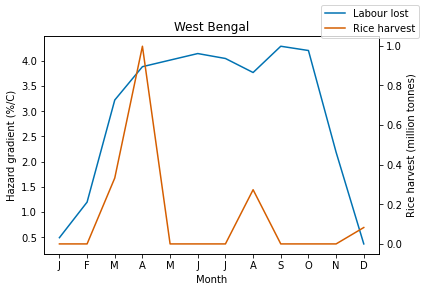

In [31]:
fig, ax = plt.subplots()
sns.lineplot(
    data=ds_monthly_trends.sel(labour_func="labour_sahu", linregress="slope")
    .where(mask_local)
    .to_dataframe(name="fit"),
    x="month",
    y="fit",
    color=sns.color_palette()[0],
    label="Labour lost",
    legend=False,
)
plt.xlabel("Month")
plt.ylabel("Hazard gradient (%/C)")
ax.set_xticks(ticks=range(1, 13))
ax.set_xticklabels(labels=[calendar.month_abbr[i][0] for i in range(1, 13)])
ax1 = ax.twinx()
prod_local = (
    ra[ra.HASC == HASC_local][
        [f"P_{calendar.month_abbr[i]}" for i in range(1, 13)]
    ].values.reshape(-1)
    / 1e6
)
ax1.plot(range(1, 13), prod_local, c=sns.color_palette()[2], label="Rice harvest")
ax1.set_ylabel("Rice harvest (million tonnes)")
fig.legend()
plt.title("West Bengal")
plt.show()

Looking at the scatterplot of labour lost against GSAT, we can see that the
reason that there is a low fitted gradient in December is because the WBGT is
mostly below the threshold of the labour loss function, so the labour lost is
clipped to 0.

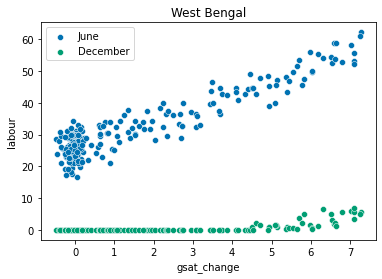

In [32]:
ds_labourloss["year"] = ds_labourloss.time.dt.year
ds_labourloss["month"] = ds_labourloss.time.dt.month
df_labourloss_monthly = (
    ds_labourloss[["labour", "year", "month"]]
    .sel(labour_func="labour_sahu")
    .where(mask_local)
    .mean(("lat", "lon"), keep_attrs=True)
    .to_dataframe()
    .reset_index()
    .groupby(["year", "month"])
    .mean()
    .reset_index()
)
df_labourloss_dec = df_labourloss_monthly[df_labourloss_monthly.month == 12]
df_labourloss_jun = df_labourloss_monthly[df_labourloss_monthly.month == 6]

df_labourloss_jun = df_labourloss_jun.set_index("year")
df_labourloss_jun["gsat_change"] = gsat_change.to_dataframe().tas

df_labourloss_dec = df_labourloss_dec.set_index("year")
df_labourloss_dec["gsat_change"] = gsat_change.to_dataframe().tas

sns.scatterplot(data=df_labourloss_jun, x="gsat_change", y="labour", label="June")
sns.scatterplot(data=df_labourloss_dec, x="gsat_change", y="labour", label="December")
plt.legend()
plt.title("West Bengal")
plt.show()

## Global trends
Having looked at the example of one location, what does the global distribution look like?

In [33]:
# Average trend by HASC, by harvest season.
ds_HASC_monthly = (
    ds_monthly_trends.where(ds_mask.mask)
    .where(ds_monthly_trends.month == da_peak_months)
    .weighted(da_weights_seasonal)
    .mean(("lon", "lat", "month"))
)
ds_HASC_monthly["weight"] = da_weights_seasonal
ds_HASC_monthly["month"] = da_peak_months.where(lambda x: x > 0)

# The same, but for the year as a whole regardless of when the harvest is.
ds_HASC_yearly = (
    ds_yearly_trends.where(ds_mask.mask)
    .weighted(da_weights_seasonal.sum("season"))
    .mean(("lon", "lat"))
)
ds_HASC_yearly["weight"] = da_weights_seasonal.sum("season")

# Now add some variables that will be useful for plotting.
def add_lat(_ds):
    """Assign a latitude for each SUB_REGION"""
    _ds["lat_"] = xr.DataArray(ra.centroid.y, dims="HASC", coords={"HASC": ra.HASC})
    return _ds


def add_country_labels(_ds):
    """Labels for marker colour and legend"""
    lookup = defaultdict(lambda: "All others")
    lookup["CN"] = "China"
    lookup["IN"] = "India"
    lookup["ID"] = "Indonesia"
    _ds["country_label"] = (
        "HASC",
        [lookup[r] for r in _ds.HASC.str[0:2].values],
    )
    _ds["COUNTRY"] = _ds.HASC.str[0:2]
    _ds["REGION"] = _ds.HASC.str[3:5]
    return _ds


ds_HASC_monthly = ds_HASC_monthly.pipe(add_lat).pipe(add_country_labels)
ds_HASC_yearly = ds_HASC_yearly.pipe(add_lat).pipe(add_country_labels)

<ipython-input-33-2af482fa2f46>:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  _ds["lat_"] = xr.DataArray(ra.centroid.y, dims="HASC", coords={"HASC": ra.HASC})


In [34]:
# Now turn it into pandas dataframes, and do weighted aggregations.
def gradient_xr_to_dataframe(_ds):
    """Convert to pandas dataframe. This makes it easier to plot with seaborn."""
    _df = (
        _ds.sel(linregress="slope", labour_func="labour_sahu")
        .to_dataframe(name="fit")
        .reset_index()
    )
    return _df


def weighted_aggregations(_df):
    """Do weighted aggregations to make the scatterplot less busy"""
    _df["weight_x_damage"] = _df.weight * _df["fit"]
    grouping = (
        ["COUNTRY", "REGION", "month"] if "month" in _df else ["COUNTRY", "REGION"]
    )
    _df = _df.groupby(grouping).aggregate(  # messy but consistent
        {
            "weight": "sum",
            "weight_x_damage": "sum",
            "lat_": "mean",
            "country_label": "first",
        }
    )
    _df["mean_damage"] = _df["weight_x_damage"] / _df["weight"]
    _df = _df.reset_index().sort_values("country_label")
    return _df


df_monthly = gradient_xr_to_dataframe(ds_HASC_monthly).pipe(weighted_aggregations)
df_yearly = gradient_xr_to_dataframe(ds_HASC_yearly).pipe(weighted_aggregations)

We can see that overall we get a very different distribution of hazard
gradients between places if we use the whole year as opposed to just the
harvest season.

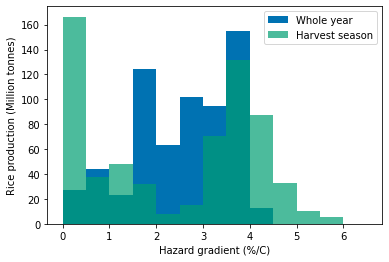

In [35]:
amax = max(df_yearly.mean_damage.max(), df_monthly.mean_damage.max())
bins = np.arange(0, amax + 0.5, 0.5)
plt.hist(
    df_yearly.mean_damage, weights=df_yearly.weight / 1e6, label="Whole year", bins=bins
)
plt.hist(
    df_monthly.mean_damage,
    weights=df_monthly.weight / 1e6,
    label="Harvest season",
    alpha=0.7,
    bins=bins,
)
plt.xlabel("Hazard gradient (%/C)")
plt.ylabel("Rice production (Million tonnes)")
plt.legend()
plt.show()

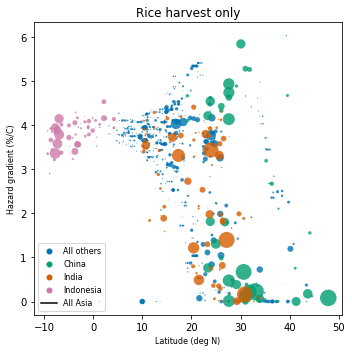

In [36]:
fig1, ax1 = plt.subplots(figsize=(5, 5))
# Scatterplot by latitude
sns.scatterplot(
    x=df_monthly.lat_,
    y=df_monthly["mean_damage"],
    size=df_monthly.weight,
    hue=df_monthly.country_label,
    sizes=(0, 300),
    size_norm=Normalize(0, df_monthly.weight.max()),
    alpha=0.8,
    ax=ax1,
    legend=False,
)
ax1.set_xlabel("Latitude (deg N)", fontsize=8)
ax1.set_ylabel("Hazard gradient (%/C)", fontsize=8)
plt.title("Rice harvest only")
plt.tight_layout()

# Use a legend
# This is constructed manually, so will not automatically update if you change
# the plots. This is because the automatic seaborn legend has extra elements I
# don't want.
legend_elements = [
    Line2D(
        [0],
        [0],
        label="All others",
        marker="o",
        color="none",
        markerfacecolor=sns.color_palette()[0],
        markeredgecolor="none",
    ),
    Line2D(
        [0],
        [0],
        label="China",
        marker="o",
        color="none",
        markerfacecolor=sns.color_palette()[1],
        markeredgecolor="none",
    ),
    Line2D(
        [0],
        [0],
        label="India",
        marker="o",
        color="none",
        markerfacecolor=sns.color_palette()[2],
        markeredgecolor="none",
    ),
    Line2D(
        [0],
        [0],
        label="Indonesia",
        marker="o",
        color="none",
        markerfacecolor=sns.color_palette()[3],
        markeredgecolor="none",
    ),
    Line2D(
        [0],
        [0],
        label="All Asia",
        color="k",
        markeredgecolor="none",
    ),
]
ax1.legend(handles=legend_elements, loc="lower left", fontsize=8)

plt.show()

This (above) scatterplot shows hazard gradient for each harvest season
and location, plotted against latitude.

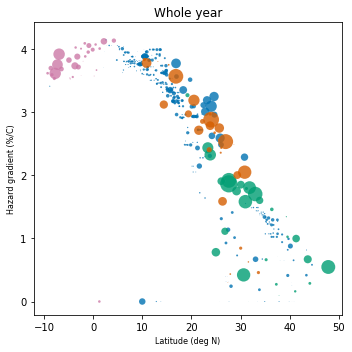

In [37]:
fig2, ax2 = plt.subplots(figsize=(5,5))
# Scatterplot by latitude
sns.scatterplot(
    x=df_yearly.lat_,
    y=df_yearly["mean_damage"],
    size=df_yearly.weight,
    hue=df_yearly.country_label,
    sizes=(0, 300),
    size_norm=Normalize(0, df_yearly.weight.max()),
    alpha=0.8,
    ax=ax2,
    legend=False,
)
ax2.set_xlabel("Latitude (deg N)", fontsize=8)
ax2.set_ylabel("Hazard gradient (%/C)", fontsize=8)
plt.title("Whole year")
plt.tight_layout()
plt.show()

This (above) scatterplot shows the hazard gradient against
latitude assuming the full year is equally weighted.

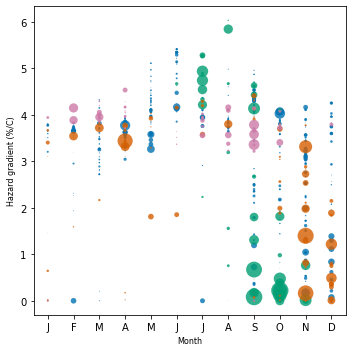

In [38]:
fig3, ax3 = plt.subplots(figsize=(5, 5))
# Scatterplot by month
sns.scatterplot(
    x=df_monthly.month,
    y=df_monthly["mean_damage"],
    size=df_monthly.weight,
    hue=df_monthly.country_label,
    sizes=(0, 300),
    size_norm=Normalize(0, df_monthly.weight.max()),
    alpha=0.8,
    ax=ax3,
    legend=False,
)

ax3.set_xticks(ticks=range(1, 13))
ax3.set_xticklabels(labels=[calendar.month_abbr[i][0] for i in range(1, 13)])
ax3.set_xlabel("Month", fontsize=8)
ax3.set_ylabel("Hazard gradient (%/C)", fontsize=8)
plt.tight_layout()

plt.show()

This (above) scatterplot shows the hazard gradient against the peak month of the harvest.

Two interacting effects explain most of the spatial variation
in the results.  Firstly, locations close to the equator have higher
temperatures. Secondly, for locations that are further from the equator there
is greater seasonal variation in temperature, so the time of year at which
the harvest occurs is important.  If the time of year of the harvest is not
considered, then the hazard gradient is mostly determined by latitude. All
large harvests that are not exposed to high hazard-gradients peak between
September and December inclusive. Close to the equator, for example in
Indonesia, hazard gradient is not very seasonally dependent as there is
little seasonal variation in temperature. By comparison, in China and India
the time of year of the harvest season has a much stronger effect on the
hazard gradient.

Labour inputs to rice production are seasonal, with more labour occurring
around planting and harvesting. This labour cannot be delayed or
displaced to other times of year, and the timeliness of these activities
affects yield and quality. Averaging across the full year assumes that labour
for any given activity can be exchanged with labour at a different time of
year, which is clearly not the case for planting and harvesting. In this
study, we have shown the importance of considering the seasonality of
agricultural labour when estimating the effect of heat-stress on labour
productivity. We have focussed only on harvesting, and only on rice; however,
each crop and each labour-intensive part of production will have its own the
seasonality that should be incorporated into estimates. Other studies into
the effect of climate change on labour productivity, even those focussed on
agricultural labour, do not take this into account.

The 50% of rice production with the highest hazard gradients between GSAT
change and labour impact is identified as being exposed to a high
hazard-gradient; the proportion of exposed production in each location is
shown in the map. We do this to identify regional differences in the
estimated labour impact; we are not suggesting this is a limit to adaptation.
Areas identified by this method include most of Southeast Asia, and coastal
South Asia. Harvests in northern India (e.g., in Punjab) are not strongly
affected.

There are some small scale variations visible, which are smaller than the
resolving scale of the climate model.  These come from variation in the
harvest dates identified in RiceAtlas, and might not always be meaningful.

threshold 3.3049970448344004


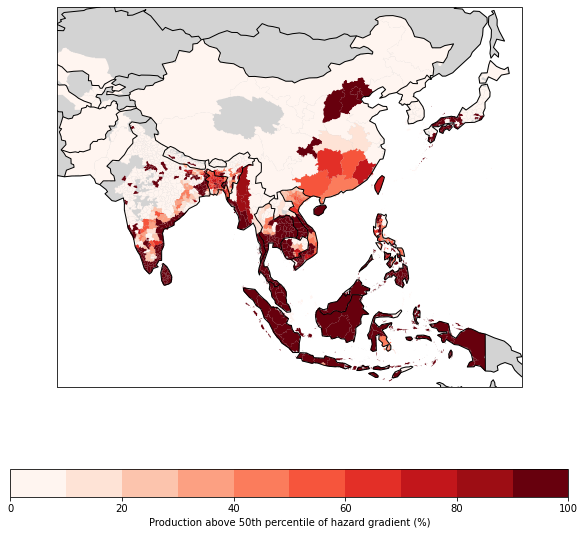

In [39]:
# Get the hazard gradient and weighting as numpy arrays
gradient = ds_HASC_monthly.sel(
    labour_func="labour_sahu", HASC=ra.HASC.values, linregress="slope"
).values
weighting = ra[[f"P_S{season}" for season in (1, 2, 3)]].values / 1e6


def weighted_quantile(x, w, q):
    wt = np.sum(w)
    wc = 0
    order = np.argsort(x.reshape(-1))
    assert x.shape == w.shape
    for point, weight in zip(x.reshape(-1)[order], w.reshape(-1)[order]):
        wc += weight
        thisq = wc / wt
        if thisq >= q:
            return point


# Find the 50th percentile
threshold = weighted_quantile(gradient, weighting, 0.5)
print("threshold", threshold)

# Identify harvests where the hazard gradient is above the threshold.
is_affected = gradient > threshold
production_affected = (weighting * is_affected).sum(-1)

# Put it back into the RiceAtlas geodataframe.
ra["production_affected"] = production_affected / weighting.sum(-1) * 100  # to %

# Plot a map.
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([60, 148, -12, 55], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.COASTLINE, facecolor="none", edgecolor="black")
ax.add_feature(cfeature.BORDERS, edgecolor="black")

bins = np.linspace(0, 100.000000001, 11)
bin_centres = (bins[1:] + bins[:-1]) / 2
ra["production_affected_quantised"] = bin_centres[
    np.digitize(ra["production_affected"], bins) - 1
]

ra.plot(
    "production_affected_quantised",
    legend=True,
    legend_kwds={
        "label": "Production above 50th percentile of hazard gradient (%)",
        "orientation": "horizontal",
        "boundaries": bins,
    },
    cmap="Reds",
    ax=ax,
)
plt.show()